#E_10 GAN
----

목차

1. GAN 베이스라인  
  
2. GAN Ver.2  
  
3. GAN Ver.3  
  
4. GAN Ver.4

## 서론
----
  
하이퍼파라미터 변경으로 성능향상을 꿈꿔보았습니다.

#### 베이스라인
----
예제 코드를 사용.  


In [ ]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.7.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

170508288/170498071 [==============================] - 11s 0us/step


In [ ]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [ ]:
train_x.shape

(50000, 32, 32, 3)

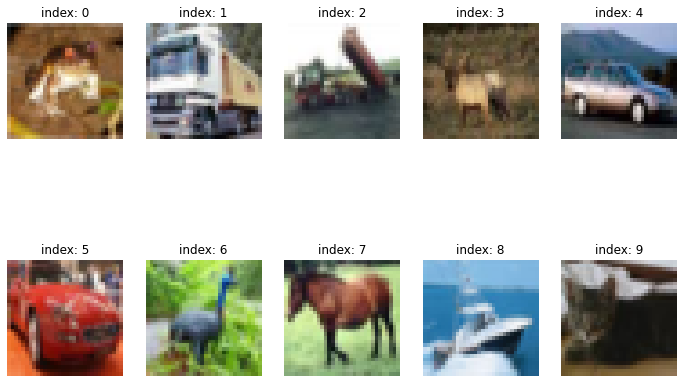

In [ ]:
plt.figure(figsize=(12, 8))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i], cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [ ]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다. (중간값을 0으로)

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

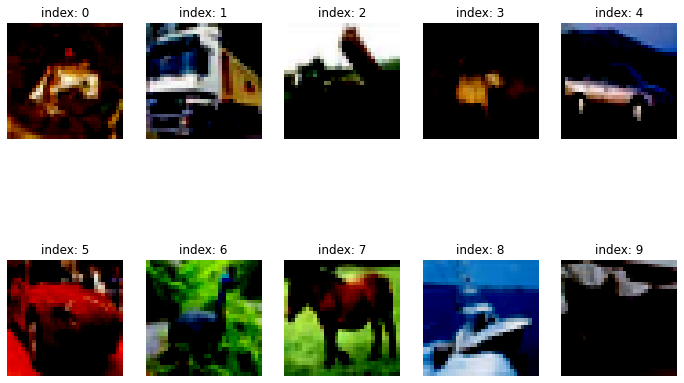

In [ ]:
plt.figure(figsize=(12, 8))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i], cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model(in_shape=(32, 32, 3)):

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

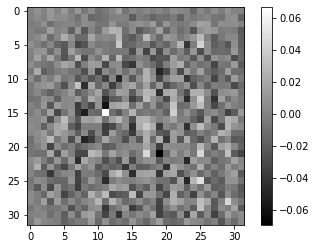

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00114387]], dtype=float32)>

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [ ]:
@tf.function
def train_step(images, gen_ver, dis_ver):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = gen_ver(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        # print(0)
        real_output = dis_ver(images, training=True)
        # print(1)
        fake_output = dis_ver(generated_images, training=True)
        # print(2)
        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, gen_ver.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, dis_ver.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen_ver.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, dis_ver.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i]*127.5 + 127.5).astype('uint8')) #(-1,1)로 정규화를 다시 (0,255)로
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/Colab_Notebooks/[E_10]/cifar10/generated_samples_2/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch, ver):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/Colab_Notebooks/[E_10]/cifar10/generated_samples_{}/train_history_{:04d}.png'
                    .format(ver,epoch))
    plt.show()

In [ ]:
def train(dataset, epochs, save_every, ver, gen_ver, dis_ver):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    checkpoint_dir = '/content/drive/MyDrive/Colab_Notebooks/[E_10]/cifar10/training_checkpoints{}'.format(ver)

    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                    discriminator_optimizer=discriminator_optimizer,
                                    generator=generator,
                                    discriminator=discriminator)
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch, gen_ver, dis_ver)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(gen_ver, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(gen_ver, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch, ver)

In [ ]:
save_every = 5
EPOCHS = 500
ver = 1
# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

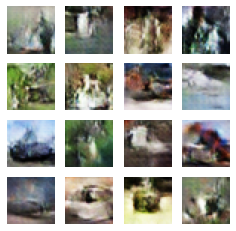

Time for training : 6995 sec


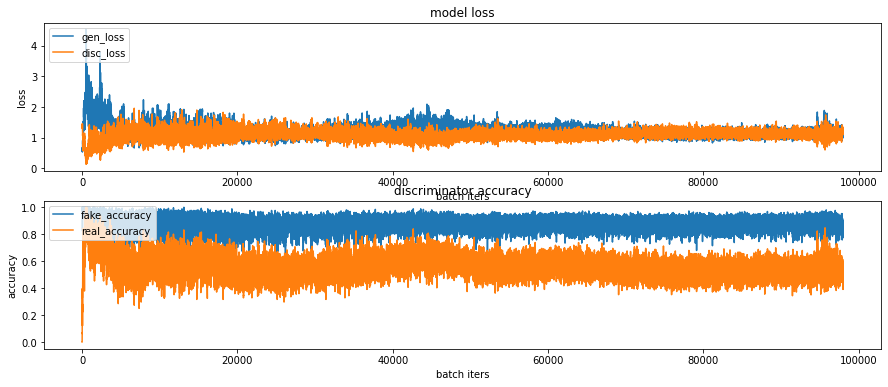

CPU times: user 1h 38min 10s, sys: 2min 50s, total: 1h 41min 1s
Wall time: 1h 56min 40s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every, ver)

#### GAN 베이스라인
----
fake accuracy는 1에 가깝지만 real accuracy가 0.5 부근에 위치하고 있는 것을 볼 수 있다. fake와 real 둘 다 0.5에 수렴하는 것이 좋은 모델이라고 하였으니 여러 하이퍼파라미터를 조정하며 더 나은 결과를 목표로 해보자.

##GAN Ver.2
----
  
변화 :  
generator_model layer 한층 추가.  
use_bias=True로 변경.  
lr=0.0002, beta_1=0.5

In [ ]:
def make_generator_model(in_shape=(32, 32, 3)):

    # Start
    model = tf.keras.Sequential()
    print(1)
    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=True, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    print(2)
    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    print(3)
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(1,1), padding='same', use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    print(4)
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2,2), padding='same', use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    print(5)
    model.add(layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(2,2), padding='same', use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), strides=(1,1), padding='same', use_bias=True, \
                                     activation='tanh'))

    return model

In [ ]:
generator_ver2 = make_generator_model()

generator.summary()

1
2
3
4
5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128

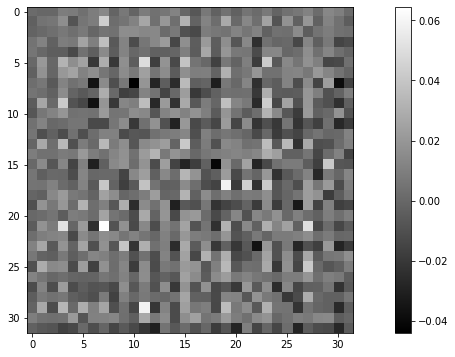

In [ ]:
noise = tf.random.normal([1, 100])
generated_image2 = generator_ver2(noise, training=False)
generated_image2.shape
plt.imshow(generated_image2[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(2,2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator_ver2 = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [ ]:
decision = discriminator(generated_image2, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[4.672266]], dtype=float32)>

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [ ]:
save_every = 5
EPOCHS = 500
ver = 2
# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")
train_dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>

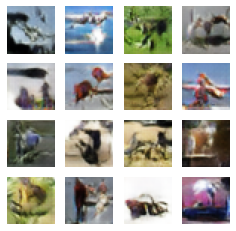

Time for training : 5143 sec


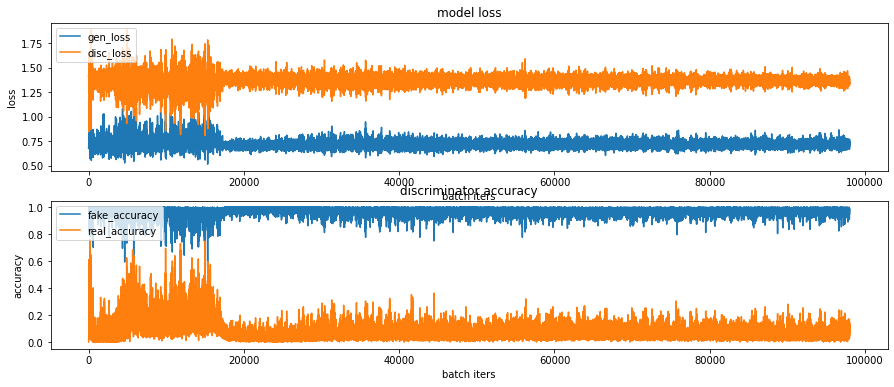

CPU times: user 1h 29min 3s, sys: 1min 49s, total: 1h 30min 52s
Wall time: 1h 25min 47s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every, ver, generator_ver2, discriminator_ver2)

#### GAN Ver.2
----
  
fake accuracy는 1에 가까이 수렴해있고, real_accuracy는 0에 가까이 수렴해버렸다. 지금와서 지표를 다시 생각해보면 discriminator는 제대로 작동하고 있고 generator의 생성에서 문제를 찾을 수 있지 않을까하는 생각이 든다.

##GAN Ver.2
----
  
변경 :  
LeakyReLU의 alpha값 변경(0.2->0.3)
use_bias=True 
generator_model channel수 향상  
모든 층에서 BatchNormalization사용  
noise 변경  
(random.nomal -> random.uniform사용, min,max(0,255)로 변경)

In [ ]:
def make_generator_model(in_shape=(32, 32, 3)):

    # Start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(4*4*64*8, use_bias=True, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))
    
    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 512)))

    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))  
    model.add(layers.Dropout(0.3))
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2,2), padding='same', use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2,2), padding='same', use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))
    
    model.add(layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(2,2), padding='same', use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), strides=(1,1), padding='same', use_bias=True, \
                                     activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8192)              827392    
                                                                 
 batch_normalization_20 (Bat  (None, 8192)             32768     
 chNormalization)                                                
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_4 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 4, 4, 256)        3277056   
 Transpose)                                                      
                                                                 
 batch_normalization_21 (Bat  (None, 4, 4, 256)       

In [ ]:
noise = tf.random.uniform(shape=[1,100], minval=0, maxval=255, seed=10)
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

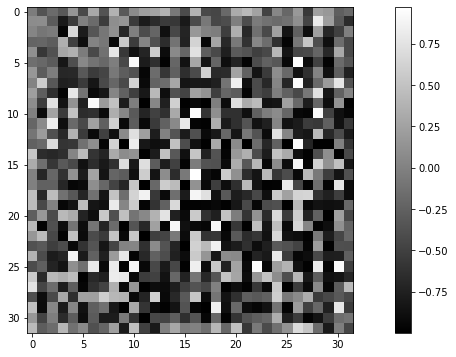

In [ ]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dropout(0.3))
    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)      

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.05454749]], dtype=float32)>

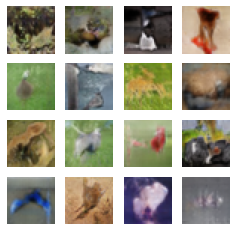

Time for training : 23927 sec


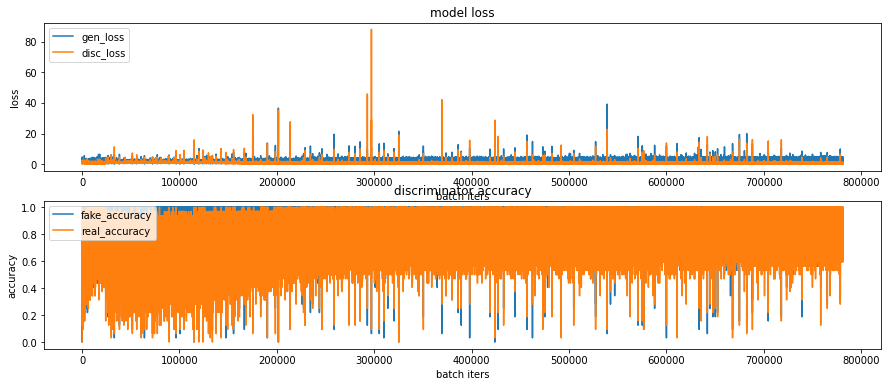

CPU times: user 5h 29min 47s, sys: 6min 53s, total: 5h 36min 40s
Wall time: 6h 39min 10s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

####GAN Ver.2 결과
----
이미지로 보면 좀 더 선명한 결과를 얻게 된 것 같고 real_accuracy가 1에 가까운 값도 많이 나오게 된 것 같다. real_accuracy가 0.5~1.0사이를 오가는 것 같고, fake_accuracy도 0.5~1.0사이를 오가는 것 같다.

##GAN Ver.3
----
  
변경:  
activation function 변경(LeakyLeRU -> ELU)  
noise생성방법 변경  
(noise = tf.random.uniform(shape=[1,100], minval=-1, maxval=1, seed=10))

In [ ]:
def make_generator_model(in_shape=(32, 32, 3)):

    # Start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(4*4*64*8, use_bias=True, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ELU(alpha=0.3))
    
    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 512)))

    model.add(layers.Conv2DTranspose(512, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.ELU(alpha=0.3))  
    model.add(layers.Dropout(0.3))
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(3, 3), strides=(2,2), padding='same', use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.ELU(alpha=0.3))
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2,2), padding='same', use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.ELU(alpha=0.3))
    
    model.add(layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2,2), padding='same', use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.ELU(alpha=0.3))
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), strides=(1,1), padding='same', use_bias=True, \
                                     activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8192)              827392    
                                                                 
 batch_normalization_10 (Bat  (None, 8192)             32768     
 chNormalization)                                                
                                                                 
 elu (ELU)                   (None, 8192)              0         
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 4, 4, 512)        6554112   
 Transpose)                                                      
                                                                 
 batch_normalization_11 (Bat  (None, 4, 4, 512)       

In [ ]:
noise = tf.random.uniform(shape=[1,100], minval=-1, maxval=1, seed=10)
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

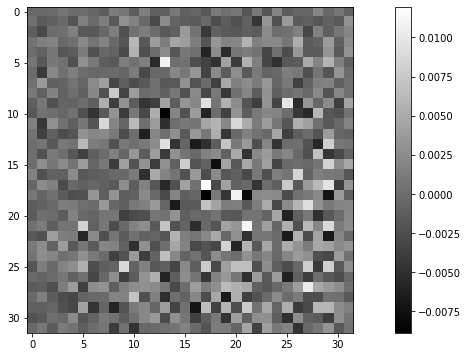

In [ ]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.ELU(alpha=0.3))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ELU(alpha=0.3))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ELU(alpha=0.3))
    # model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ELU(alpha=0.3))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ELU(alpha=0.3))
    # model.add(layers.Dropout(0.3))
    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_15 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 elu_5 (ELU)                 (None, 32, 32, 64)        0         
                                                                 
 dropout_23 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_16 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                     

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-3.6489437e-05]], dtype=float32)>

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

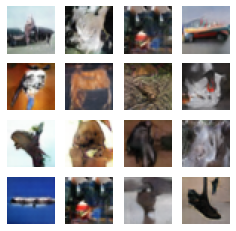

Epoch 345 | iter 151
Time for epoch 345 : 31 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

####GAN Ver.3 결과
----

꽤나 기대를 많이 했었는데 런타임이 중간에 날아가서 결과를 끝까지 보지 못했던 것이 굉장히 아쉽다. 이미지만 보자면 우측 상단에 자동차가 굉장히 잘 그려진 느낌이다.  
  
![train_history_0444](https://user-images.githubusercontent.com/96756158/154086234-fa676624-7393-49d0-a384-6eb6dce616bf.png)


##GAN Ver.2.1
----
변경:  
Ver.2에서 noise생성만 변경  
min,max(-1, 1)

In [ ]:
def make_generator_model(in_shape=(32, 32, 3)):
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(4*4*64*8, use_bias=True, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))
    
    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 512)))

    model.add(layers.Conv2DTranspose(512, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))  
    model.add(layers.Dropout(0.3))
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(3, 3), strides=(2,2), padding='same', use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2,2), padding='same', use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))
    
    model.add(layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2,2), padding='same', use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), strides=(1,1), padding='same', use_bias=True, \
                                     activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              827392    
                                                                 
 batch_normalization_10 (Bat  (None, 8192)             32768     
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 4, 4, 512)        6554112   
 ranspose)                                                       
                                                                 
 batch_normalization_11 (Bat  (None, 4, 4, 512)       

In [ ]:
noise = tf.random.uniform(shape=[1,100], minval=-1, maxval=1, seed=10)
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

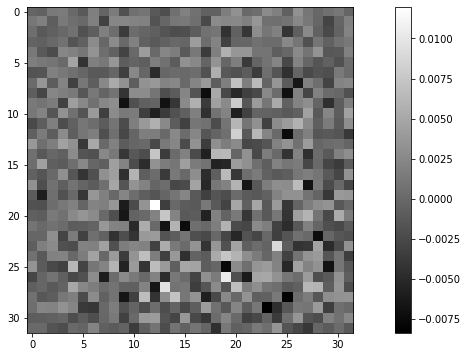

In [ ]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
def make_discriminator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dropout(0.3))
    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 256)      

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00012424]], dtype=float32)>

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

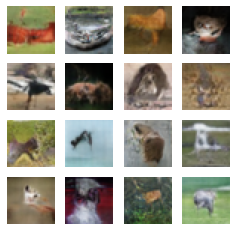

Time for training : 58644 sec


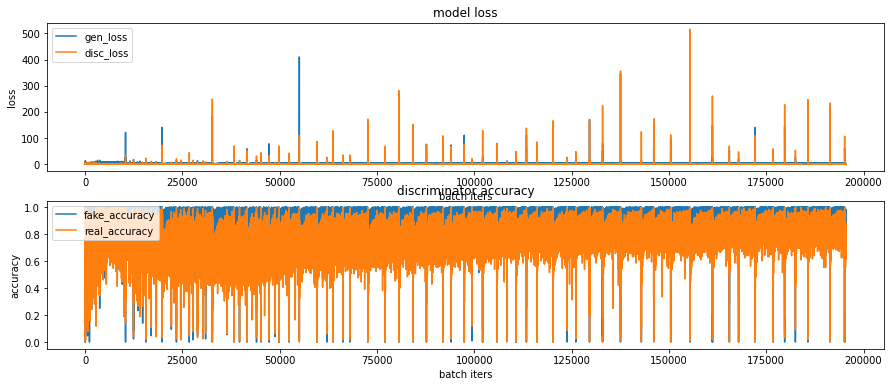

CPU times: total: 12h 41min 50s
Wall time: 16h 17min 42s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

####GAN Ver.2.1 회고
----
  
이해할 수 없는 현상이다 오히려 성능향상을 기대했는데 그래프로 보나 이미지로 보나 성능이 하락된 것 같다. loss가 꾸준히 낮은 것은 괜찮은 것 같지만 중간중간 loss가 튀는 것을 보면 overfitting인가 하는 생각도 든다.

## 총 회고
----
  
굉장히 어려웠던 익스였고, 확실한 결과물이 없는 것 같아서 너무 아쉽다. 의미있는 생성물을 만들어 보고 싶었으나, 그렇다할 성과가 없는 것 같다. 하나 건진것은 Ver.3에서 자동차가 깔끔하게 나온것이 있어서 마음에 든다 저 이미지가 아마도 ELU를 사용했던 모델에서 만들어진 이미지라 ELU사용이 의미가 있다고 생각된다. 그리고 Drop out의 성능에 대해 몸소 체험하게 되는 계기가 된거 같고 momentum을 써보지 못한게 아쉽다.  
베이스라인    
![dcgan_ver1](https://user-images.githubusercontent.com/96756158/154085576-d458b95e-8b7d-4009-824c-c531880e1e69.gif)  
  
gan_ver.2  
![dcgan_ver2](https://user-images.githubusercontent.com/96756158/154085568-02cd2fab-504d-43aa-a004-42f7ed5005f1.gif)  
  
gan_ver.3  
![dcgan_ver3](https://user-images.githubusercontent.com/96756158/154085518-40570533-cbc1-4a7a-b9cf-cfecce5ef336.gif)
  
gan_ver.2.1  
![dcgan_ver4](https://user-images.githubusercontent.com/96756158/154085558-eb4aafce-f80a-435e-80aa-849c915920e4.gif)
